# 1. Importing starting code :

In [104]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import os

# very useful for zoomable plots in Jupyter notebooks
%matplotlib widget

# 2. Plotting raw time series + raw trajectory data :

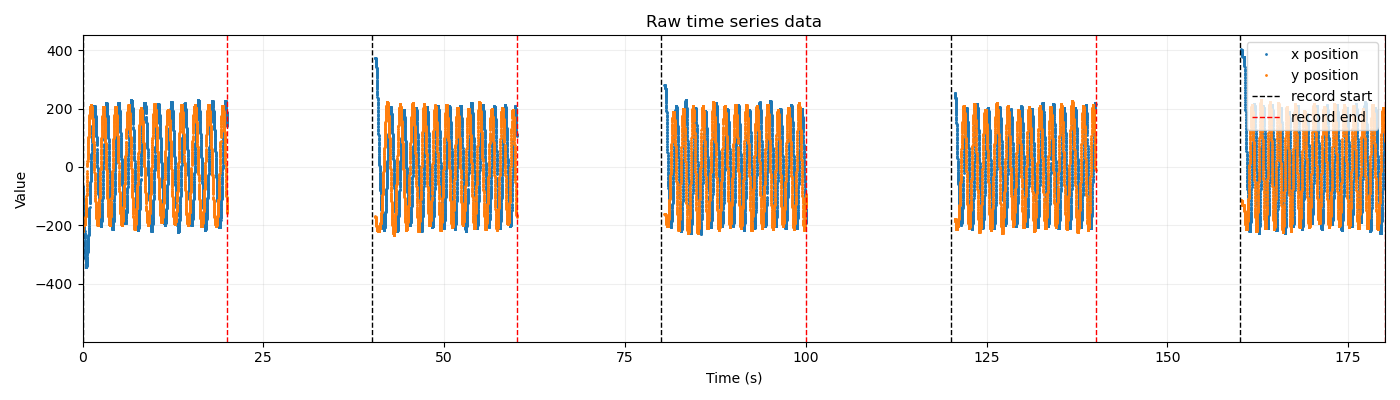

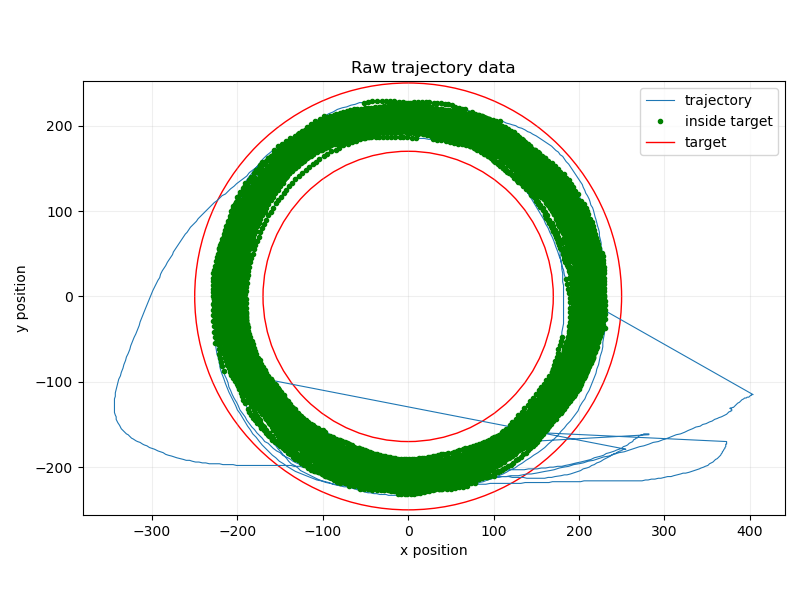

In [105]:
# Load raw CSVs and reproduce time series and trajectory using header + markers
# Uses only numpy, matplotlib.pyplot, and os

# Filenames
base_dir = os.getcwd()
raw_csv = os.path.join(base_dir, '001MoDe_R1.csv')
marker_csv = os.path.join(base_dir, '001MoDe_R1.marker.csv')

# Helper: find the header line index containing the provided header text
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    return None

# Read header parameters from the first line of the data CSV
with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
    header = f.readline().strip()

params = {}
for part in header.split(';'):
    part = part.strip()
    if not part:
        continue
    if ' ' in part:
        key, val = part.split(' ', 1)
        key = key.strip()
        val = val.strip()
        try:
            params[key] = float(val)
        except Exception:
            params[key] = val

center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw mouse data (timestamp, mouseX, mouseY, mouseInTarget)
header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
if header_line is None:
    raise RuntimeError('Could not find data header in 001MoDe_R1.csv')

raw_data = np.genfromtxt(
    raw_csv,
    delimiter=',',
    names=True,
    skip_header=header_line,
    dtype=None,
    encoding=None
)

# Extract arrays and sort by timestamp
timestamps = raw_data['timestamp'].astype(np.int64)
sort_idx = np.argsort(timestamps)
timestamps = timestamps[sort_idx]
mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]

# Relative coordinates (origin at task center), invert y so up is positive
x_rel = mouse_x - center_x
y_rel = (center_y - mouse_y)

# Parse marker file to get explicit record (work) intervals
record_starts = []
record_ends = []
with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
            parts = [p.strip() for p in s.split(',')]
            if len(parts) >= 3:
                try:
                    epoch_ms = int(parts[1])
                except Exception:
                    continue
                if 'DoCycleChange:DoRecord' in s:
                    record_starts.append(epoch_ms)
                elif 'DoCycleChange:DoPause' in s:
                    record_ends.append(epoch_ms)

# Align time axis to the first DoRecord marker
t0_record = int(record_starts[0]) if record_starts else int(timestamps[0])
t_sec = (timestamps - t0_record) / 1000.0

# Build arrays of start/end times in seconds relative to first DoRecord
start_times = np.array([(ms - t0_record) / 1000.0 for ms in record_starts], dtype=float)
end_times = np.array([(ms - t0_record) / 1000.0 for ms in record_ends], dtype=float)

# Build mask of samples that occur within any record interval
mask_record = np.zeros_like(t_sec, dtype=bool)
for s, e in zip(start_times, end_times):
    mask_record |= ((t_sec >= s) & (t_sec <= e))

# Plot 1: Raw time series with record on/off markers
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t_sec, x_rel, '.', ms=2, label='x position')
ax.plot(t_sec, y_rel, '.', ms=2, label='y position')
for s in start_times:
    ax.axvline(s, color='k', linestyle='--', linewidth=1, label='record start' if s == start_times[0] else None)
for e in end_times:
    ax.axvline(e, color='r', linestyle='--', linewidth=1, label='record end' if e == end_times[0] else None)
ax.set_title('Raw time series data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Value')
ax.set_xlim(0.0, float(np.max(t_sec)))
ax.legend(loc='upper right')
ax.grid(True, alpha=0.2)
fig.tight_layout()

# Plot 2: Raw trajectory with target annulus and in-target highlights (only during record)
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
ax2.plot(x_rel[mask_record], y_rel[mask_record], color='tab:blue', linewidth=0.8, label='trajectory')
mask = (in_target == 1) & mask_record
if np.any(mask):
    ax2.plot(x_rel[mask], y_rel[mask], 'o', ms=3, color='green', label='inside target')

circle_inner = plt.Circle((0, 0), internal_r, fill=False, color='red', linewidth=1)
circle_outer = plt.Circle((0, 0), external_r, fill=False, color='red', linewidth=1)
ax2.add_artist(circle_inner)
ax2.add_artist(circle_outer)

# Add legend entry for target annulus
ax2.plot([], [], color='red', linewidth=1, label='target')

ax2.set_aspect('equal', adjustable='box')
ax2.set_title('Raw trajectory data')
ax2.set_xlabel('x position')
ax2.set_ylabel('y position')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.2)
fig2.tight_layout()

In [106]:
# Compute record sample counts/times from raw CSV and recompute stats from marker CSV
import numpy as np
import os

# Paths (reusing variables from Cell 4 if present)
base_dir = os.getcwd()
raw_csv = globals().get('raw_csv', os.path.join(base_dir, '001MoDe_R1.csv'))
marker_csv = globals().get('marker_csv', os.path.join(base_dir, '001MoDe_R1.marker.csv'))

# Helper to find the data header line in the raw CSV
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    raise RuntimeError('Could not find data header in %s' % path)

# Parse marker CSV for DoRecord/DoPause epoch times and for the trailing stats table
record_starts_epoch = []
record_ends_epoch = []
trailing_stats_lines = []
with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
    collect_stats = False
    for line in f:
        s = line.rstrip('\n')
        if not s.strip():
            continue
        if ('DoCycleChange:DoRecord' in s) or ('DoCycleChange:DoPause' in s):
            parts = [p.strip() for p in s.split(',')]
            if len(parts) >= 3:
                try:
                    epoch_ms = int(parts[1])
                except Exception:
                    continue
                if 'DoCycleChange:DoRecord' in s:
                    record_starts_epoch.append(epoch_ms)
                elif 'DoCycleChange:DoPause' in s:
                    record_ends_epoch.append(epoch_ms)
        # The trailing stats table begins with a line starting with 'Var , nLaps'
        if s.lstrip().startswith('Var , nLaps'):
            collect_stats = True
            trailing_stats_lines.append(s)
            continue
        if collect_stats:
            trailing_stats_lines.append(s)

# Align to first DoRecord
if not record_starts_epoch or not record_ends_epoch:
    raise RuntimeError('No record intervals found in marker file')

# Load raw data timestamps
header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
raw_data = np.genfromtxt(
    raw_csv,
    delimiter=',',
    names=True,
    skip_header=header_line,
    dtype=None,
    encoding=None
)

timestamps = raw_data['timestamp'].astype(np.int64)
sort_idx = np.argsort(timestamps)
timestamps = timestamps[sort_idx]

# Relative time in seconds to the first DoRecord epoch
t0_record = int(record_starts_epoch[0])
t_sec = (timestamps - t0_record) / 1000.0

# Build per-record lines
nrec = min(len(record_starts_epoch), len(record_ends_epoch))
rec_lines = []
for i in range(nrec):
    s_ms = record_starts_epoch[i]
    e_ms = record_ends_epoch[i]
    s_rel = (s_ms - t0_record) / 1000.0
    e_rel = (e_ms - t0_record) / 1000.0
    m = (t_sec >= s_rel) & (t_sec <= e_rel)
    if not np.any(m):
        n = 0
        tmin = float('nan')
        tmax = float('nan')
        dt = float('nan')
        fs = float('nan')
    else:
        n = int(np.count_nonzero(m))
        tmin = float(np.min(t_sec[m]))
        tmax = float(np.max(t_sec[m]))
        dt = tmax - tmin
        fs = (n - 1) / dt if dt > 0 else float('nan')
    rec_lines.append(
        f"record {i}: {n:4d} samples from {tmin:7.3f} to {tmax:7.3f} s, ({dt:6.3f}s, {fs:7.3f} Hz)"
    )

# Parse trailing stats rows and transform per requirement
# Expect lines like 'Theory ,  1.00 ,  209.50 ,   47.00 ,    3.88 , ...'
# and 'Rec00X , ...'
parsed_rows = []
for s in trailing_stats_lines:
    if s.strip().startswith(('Theory', 'Rec001', 'Rec002', 'Rec003', 'Rec004', 'Rec005')):
        # Split on commas, strip spaces
        parts = [p.strip() for p in s.split(',')]
        if not parts:
            continue
        name = parts[0]
        # Keep header 'Theory' as-is; for Rec*** rows, adjust columns
        if name == 'Theory':
            parsed_rows.append(('Theory', [parts[1:]]))
        elif name.startswith('Rec'):
            # Columns by marker: Var, Re, Te, error, MT/lap, IDe/lap, Be, IPe (some rows may have trailing empties)
            # Convert to floats where possible
            nums = []
            for p in parts[1:9]:
                try:
                    nums.append(float(p))
                except Exception:
                    nums.append(np.nan)
            # Transformations: Var -> abs, error -> 100 - error
            if len(nums) >= 1 and np.isfinite(nums[0]):
                nums[0] = abs(nums[0])
            if len(nums) >= 4 and np.isfinite(nums[3]):
                nums[3] = 100.0 - nums[3]
            parsed_rows.append((name, nums))

# Build the exact output text
out_lines = []
out_lines.append(f"Number of records: {nrec}")
out_lines.extend(rec_lines)
out_lines.append("recomputed statistics for all records:")
# Add headers exactly as requested
out_lines.append("   Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,")
out_lines.append("  unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,")
out_lines.append("Theory ,  1.00 ,  209.50 ,   47.00 ,    3.88 ,         ,         ,    1.00 ,         ,")
# Format Rec001..Rec005 using 2 decimals (or 2 for Var and integer-like as shown)
name_order = [f"Rec{idx:03d}" for idx in range(1, 6)]
for name in name_order:
    row = next((r for r in parsed_rows if r[0] == name), None)
    if not row:
        continue
    nums = row[1]
    # Defensive length
    while len(nums) < 8:
        nums.append(np.nan)
    Var, Re, Te, err, MT, IDe, Be, IPe = nums[:8]
    out_lines.append(
        (
            f"{name} , {Var:5.2f} ,  {Re:6.2f} ,   {Te:5.2f} ,   {err:5.2f} ,"
            f"    {MT:4.2f} ,   {IDe:5.2f} ,    {Be:3.2f} ,   {IPe:5.2f} ,"
        )
    )

print("\n".join(out_lines))

Number of records: 5
record 0: 3971 samples from   0.018 to  20.000 s, (19.982s, 198.679 Hz)
record 1: 3898 samples from  40.425 to  60.014 s, (19.589s, 198.938 Hz)
record 2: 3898 samples from  80.367 to 100.046 s, (19.679s, 198.028 Hz)
record 3: 3884 samples from 120.604 to 140.065 s, (19.461s, 199.527 Hz)
record 4: 3936 samples from 160.142 to 180.094 s, (19.952s, 197.223 Hz)
recomputed statistics for all records:
   Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,
  unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,
Theory ,  1.00 ,  209.50 ,   47.00 ,    3.88 ,         ,         ,    1.00 ,         ,
Rec001 , 10.85 ,  213.87 ,   91.79 ,   96.10 ,    1.84 ,   14.64 ,    1.95 ,    7.94 ,
Rec002 , 11.97 ,  209.85 ,   34.46 ,   99.26 ,    1.59 ,   38.27 ,    0.73 ,   24.04 ,
Rec003 , 13.26 ,  209.43 ,   42.42 ,   97.19 ,    1.45 ,   31.02 ,    0.90 ,   21.40 ,
Rec004 , 12.83 ,  209.46 ,   37.14 ,   99.87 ,    1.49 ,  

# 3. Plotting record data :

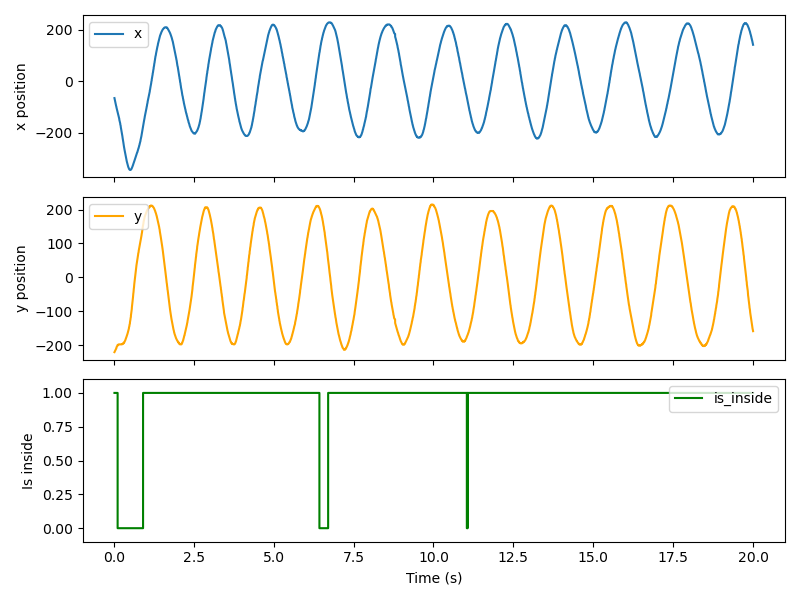

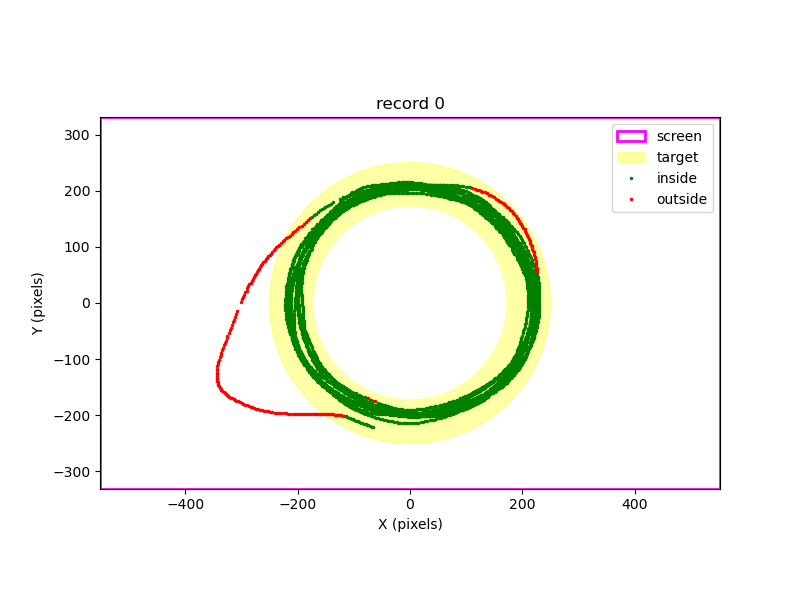

In [107]:
# Record 0 plots: trajectory with screen/target + x, y, is_inside vs time

from matplotlib.patches import Rectangle, Circle

# Ensure paths
base_dir = os.getcwd()
raw_csv = globals().get('raw_csv', os.path.join(base_dir, '001MoDe_R1.csv'))
marker_csv = globals().get('marker_csv', os.path.join(base_dir, '001MoDe_R1.marker.csv'))

# Helper to find header line for numeric table in raw csv
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    raise RuntimeError('Could not find data header in %s' % path)

# Parse parameter header if not already available
if 'params' not in globals():
    with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
        param_line = f.readline().strip()
    params = {}
    for part in param_line.split(';'):
        part = part.strip()
        if not part:
            continue
        if ' ' in part:
            k, v = part.split(' ', 1)
            k = k.strip(); v = v.strip()
            try:
                params[k] = float(v)
            except Exception:
                params[k] = v

# Extract dimensions and radii
screen_w = int(params.get('screenWidth', 1104))
screen_h = int(params.get('screenHeight', 661))
center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw data arrays if needed
if 't_sec' not in globals() or 'x_rel' not in globals() or 'y_rel' not in globals() or 'in_target' not in globals() or 'start_times' not in globals() or 'end_times' not in globals():
    header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
    raw_data = np.genfromtxt(
        raw_csv,
        delimiter=',',
        names=True,
        skip_header=header_line,
        dtype=None,
        encoding=None
    )
    timestamps = raw_data['timestamp'].astype(np.int64)
    sort_idx = np.argsort(timestamps)
    timestamps = timestamps[sort_idx]
    mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
    mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
    in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]
    # relative coordinates (origin at screen center), invert y so up is positive
    x_rel = mouse_x - center_x
    y_rel = (center_y - mouse_y)
    # parse record intervals from marker file
    starts_epoch = []
    ends_epoch = []
    with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
                parts = [p.strip() for p in s.split(',')]
                if len(parts) >= 3:
                    try:
                        epoch_ms = int(parts[1])
                    except Exception:
                        continue
                    if 'DoCycleChange:DoRecord' in s:
                        starts_epoch.append(epoch_ms)
                    elif 'DoCycleChange:DoPause' in s:
                        ends_epoch.append(epoch_ms)
    t0_record = int(starts_epoch[0])
    t_sec = (timestamps - t0_record) / 1000.0
    start_times = np.array([(ms - t0_record) / 1000.0 for ms in starts_epoch], dtype=float)
    end_times = np.array([(ms - t0_record) / 1000.0 for ms in ends_epoch], dtype=float)

# Mask for record 0
mask0 = (t_sec >= start_times[0]) & (t_sec <= end_times[0])
ins0 = (in_target[mask0] == 1)

x0 = x_rel[mask0]
y0 = y_rel[mask0]
t0 = t_sec[mask0]

# ---- Plot A: XY trajectory with screen and target annulus ----
figA, axA = plt.subplots(1, 1, figsize=(8, 6))
# screen rectangle centered at (0,0)
axA.add_patch(Rectangle((-screen_w/2, -screen_h/2), screen_w, screen_h,
                        fill=False, edgecolor='magenta', linewidth=2, label='screen'))
# target annulus (filled)
outer = Circle((0, 0), external_r, color='yellow', alpha=0.35, fill=True, label='target')
inner = Circle((0, 0), internal_r, color='white', alpha=1.0, fill=True)
axA.add_patch(outer)
axA.add_patch(inner)
# points
axA.plot(x0[ins0], y0[ins0], '.', color='green', markersize=3, label='inside')
axA.plot(x0[~ins0], y0[~ins0], '.', color='red', markersize=3, label='outside')
axA.set_title('record 0')
axA.set_xlabel('X (pixels)')
axA.set_ylabel('Y (pixels)')
axA.set_aspect('equal', adjustable='box')
axA.set_xlim(-screen_w/2, screen_w/2)
axA.set_ylim(-screen_h/2, screen_h/2)
axA.legend(loc='upper right')
axA.grid(False)

# ---- Plot B: x, y and is_inside vs time ----
figB, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(t0, x0, color='tab:blue', label='x')
axes[0].set_ylabel('x position')
axes[0].legend(loc='upper left')

axes[1].plot(t0, y0, color='orange', label='y')
axes[1].set_ylabel('y position')
axes[1].legend(loc='upper left')

axes[2].plot(t0, ins0.astype(int), color='green', drawstyle='steps-post', label='is_inside')
axes[2].set_ylim(-0.1, 1.1)
axes[2].set_ylabel('Is inside')
axes[2].set_xlabel('Time (s)')
axes[2].legend(loc='upper right')

figB.tight_layout()
plt.show()

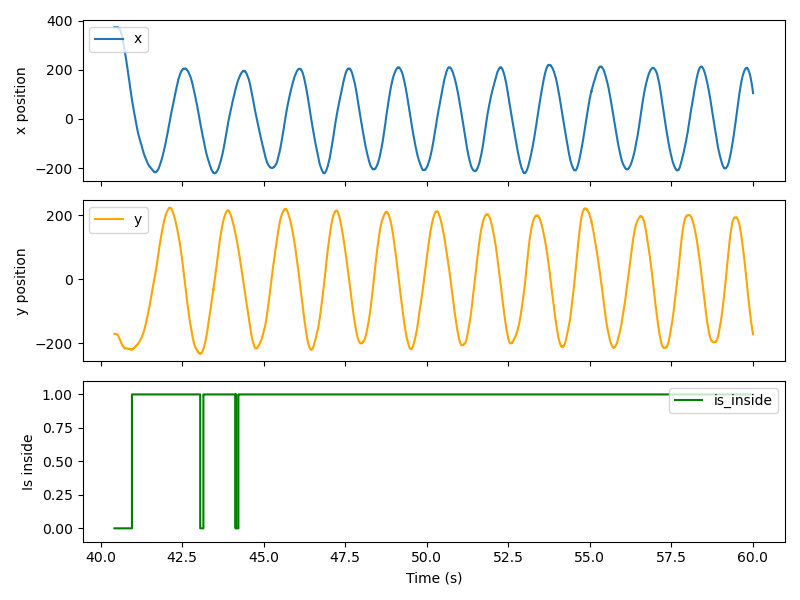

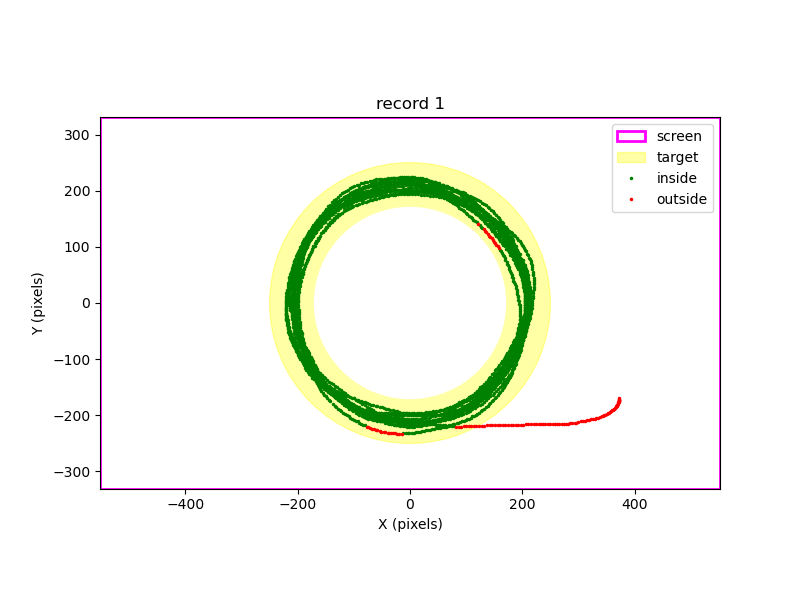

In [108]:
# Record 1 plots: trajectory with screen/target + x, y, is_inside vs time

# Ensure paths
base_dir = os.getcwd()
raw_csv = globals().get('raw_csv', os.path.join(base_dir, '001MoDe_R1.csv'))
marker_csv = globals().get('marker_csv', os.path.join(base_dir, '001MoDe_R1.marker.csv'))

# Helper to find header line for numeric table in raw csv
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    raise RuntimeError('Could not find data header in %s' % path)

# Parse parameter header if not already available
if 'params' not in globals():
    with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
        param_line = f.readline().strip()
    params = {}
    for part in param_line.split(';'):
        part = part.strip()
        if not part:
            continue
        if ' ' in part:
            k, v = part.split(' ', 1)
            k = k.strip(); v = v.strip()
            try:
                params[k] = float(v)
            except Exception:
                params[k] = v

# Extract dimensions and radii
screen_w = int(params.get('screenWidth', 1104))
screen_h = int(params.get('screenHeight', 661))
center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw data arrays if needed
if 't_sec' not in globals() or 'x_rel' not in globals() or 'y_rel' not in globals() or 'in_target' not in globals() or 'start_times' not in globals() or 'end_times' not in globals():
    header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
    raw_data = np.genfromtxt(
        raw_csv,
        delimiter=',',
        names=True,
        skip_header=header_line,
        dtype=None,
        encoding=None
    )
    timestamps = raw_data['timestamp'].astype(np.int64)
    sort_idx = np.argsort(timestamps)
    timestamps = timestamps[sort_idx]
    mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
    mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
    in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]
    # relative coordinates (origin at screen center), invert y so up is positive
    x_rel = mouse_x - center_x
    y_rel = (center_y - mouse_y)
    # parse record intervals from marker file
    starts_epoch = []
    ends_epoch = []
    with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
                parts = [p.strip() for p in s.split(',')]
                if len(parts) >= 3:
                    try:
                        epoch_ms = int(parts[1])
                    except Exception:
                        continue
                    if 'DoCycleChange:DoRecord' in s:
                        starts_epoch.append(epoch_ms)
                    elif 'DoCycleChange:DoPause' in s:
                        ends_epoch.append(epoch_ms)
    t0_record = int(starts_epoch[0])
    t_sec = (timestamps - t0_record) / 1000.0
    start_times = np.array([(ms - t0_record) / 1000.0 for ms in starts_epoch], dtype=float)
    end_times = np.array([(ms - t0_record) / 1000.0 for ms in ends_epoch], dtype=float)

# ---- Select record 1 ----
rec_idx = 1
if rec_idx >= len(start_times):
    raise IndexError("Record 1 not found in markers.")

mask1 = (t_sec >= start_times[rec_idx]) & (t_sec <= end_times[rec_idx])
ins1 = (in_target[mask1] == 1)

x1 = x_rel[mask1]
y1 = y_rel[mask1]
t1 = t_sec[mask1]

# ---- Plot A: XY trajectory with screen and target annulus (record 1 first) ----
figA, axA = plt.subplots(1, 1, figsize=(8, 6))
axA.add_patch(Rectangle((-screen_w/2, -screen_h/2), screen_w, screen_h,
                        fill=False, edgecolor='magenta', linewidth=2, label='screen'))
outer = Circle((0, 0), external_r, color='yellow', alpha=0.35, fill=True, label='target')
inner = Circle((0, 0), internal_r, color='white', alpha=1.0, fill=True)
axA.add_patch(outer)
axA.add_patch(inner)
axA.plot(x1[ins1], y1[ins1], '.', color='green', markersize=3, label='inside')
axA.plot(x1[~ins1], y1[~ins1], '.', color='red', markersize=3, label='outside')
axA.set_title('record 1')
axA.set_xlabel('X (pixels)')
axA.set_ylabel('Y (pixels)')
axA.set_aspect('equal', adjustable='box')
axA.set_xlim(-screen_w/2, screen_w/2)
axA.set_ylim(-screen_h/2, screen_h/2)
axA.legend(loc='upper right')
axA.grid(False)

# ---- Plot B: x, y and is_inside vs time (record 1) ----
figB, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(t1, x1, color='tab:blue', label='x')
axes[0].set_ylabel('x position')
axes[0].legend(loc='upper left')

axes[1].plot(t1, y1, color='orange', label='y')
axes[1].set_ylabel('y position')
axes[1].legend(loc='upper left')

axes[2].plot(t1, ins1.astype(int), color='green', drawstyle='steps-post', label='is_inside')
axes[2].set_ylim(-0.1, 1.1)
axes[2].set_ylabel('Is inside')
axes[2].set_xlabel('Time (s)')
axes[2].legend(loc='upper right')

figB.tight_layout()
plt.show()

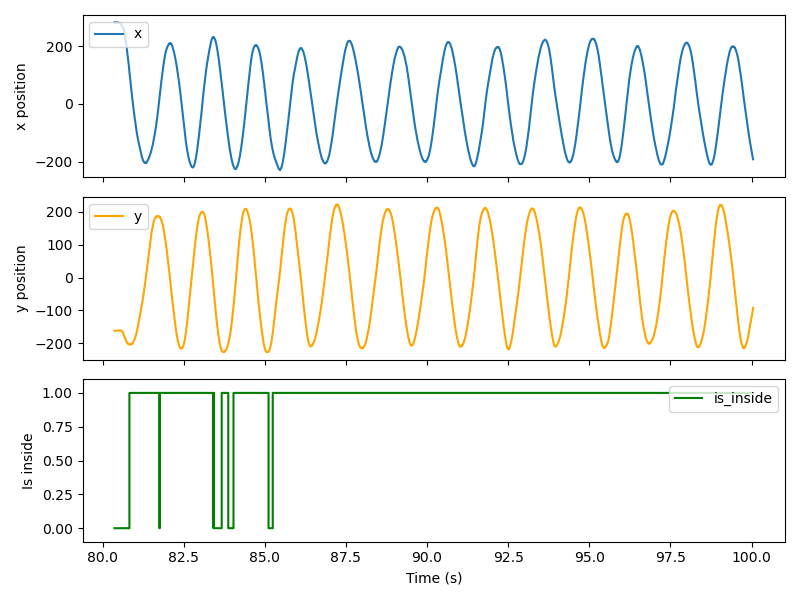

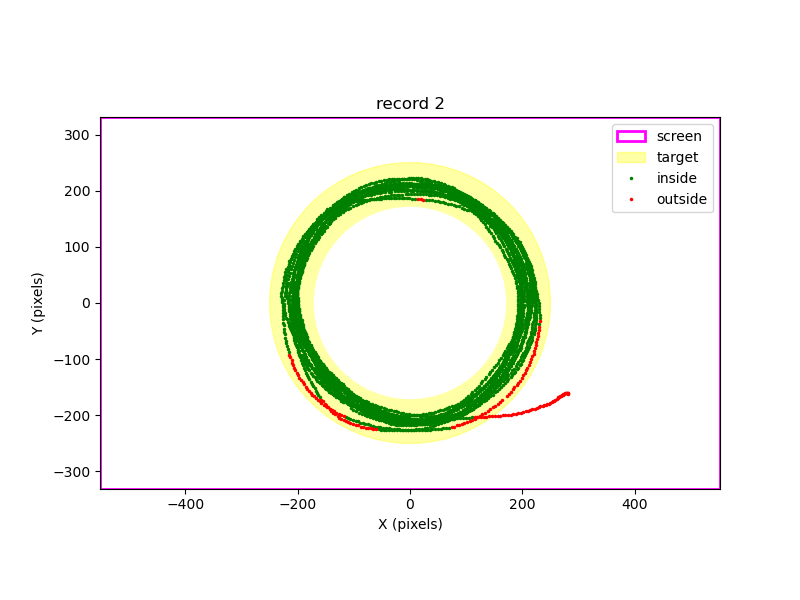

In [109]:
# Record 2 plots: trajectory with screen/target + x, y, is_inside vs time

# Ensure paths
base_dir = os.getcwd()
raw_csv = globals().get('raw_csv', os.path.join(base_dir, '001MoDe_R1.csv'))
marker_csv = globals().get('marker_csv', os.path.join(base_dir, '001MoDe_R1.marker.csv'))

# Helper to find header line for numeric table in raw csv
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    raise RuntimeError('Could not find data header in %s' % path)

# Parse parameter header if not already available
if 'params' not in globals():
    with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
        param_line = f.readline().strip()
    params = {}
    for part in param_line.split(';'):
        part = part.strip()
        if not part:
            continue
        if ' ' in part:
            k, v = part.split(' ', 1)
            k = k.strip(); v = v.strip()
            try:
                params[k] = float(v)
            except Exception:
                params[k] = v

# Extract dimensions and radii
screen_w = int(params.get('screenWidth', 1104))
screen_h = int(params.get('screenHeight', 661))
center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw data arrays if needed
if 't_sec' not in globals() or 'x_rel' not in globals() or 'y_rel' not in globals() or 'in_target' not in globals() or 'start_times' not in globals() or 'end_times' not in globals():
    header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
    raw_data = np.genfromtxt(
        raw_csv,
        delimiter=',',
        names=True,
        skip_header=header_line,
        dtype=None,
        encoding=None
    )
    timestamps = raw_data['timestamp'].astype(np.int64)
    sort_idx = np.argsort(timestamps)
    timestamps = timestamps[sort_idx]
    mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
    mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
    in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]
    # relative coordinates (origin at screen center), invert y so up is positive
    x_rel = mouse_x - center_x
    y_rel = (center_y - mouse_y)
    # parse record intervals from marker file
    starts_epoch = []
    ends_epoch = []
    with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
                parts = [p.strip() for p in s.split(',')]
                if len(parts) >= 3:
                    try:
                        epoch_ms = int(parts[1])
                    except Exception:
                        continue
                    if 'DoCycleChange:DoRecord' in s:
                        starts_epoch.append(epoch_ms)
                    elif 'DoCycleChange:DoPause' in s:
                        ends_epoch.append(epoch_ms)
    t0_record = int(starts_epoch[0])
    t_sec = (timestamps - t0_record) / 1000.0
    start_times = np.array([(ms - t0_record) / 1000.0 for ms in starts_epoch], dtype=float)
    end_times = np.array([(ms - t0_record) / 1000.0 for ms in ends_epoch], dtype=float)

# ---- Select record 2 ----
rec_idx = 2
if rec_idx >= len(start_times):
    raise IndexError("Record 2 not found in markers.")

mask2 = (t_sec >= start_times[rec_idx]) & (t_sec <= end_times[rec_idx])
ins2 = (in_target[mask2] == 1)

x2 = x_rel[mask2]
y2 = y_rel[mask2]
t2 = t_sec[mask2]

# ---- Plot A: XY trajectory with screen and target annulus (record 2) ----
figA, axA = plt.subplots(1, 1, figsize=(8, 6))
axA.add_patch(Rectangle((-screen_w/2, -screen_h/2), screen_w, screen_h,
                        fill=False, edgecolor='magenta', linewidth=2, label='screen'))
outer = Circle((0, 0), external_r, color='yellow', alpha=0.35, fill=True, label='target')
inner = Circle((0, 0), internal_r, color='white', alpha=1.0, fill=True)
axA.add_patch(outer)
axA.add_patch(inner)
axA.plot(x2[ins2], y2[ins2], '.', color='green', markersize=3, label='inside')
axA.plot(x2[~ins2], y2[~ins2], '.', color='red', markersize=3, label='outside')
axA.set_title('record 2')
axA.set_xlabel('X (pixels)')
axA.set_ylabel('Y (pixels)')
axA.set_aspect('equal', adjustable='box')
axA.set_xlim(-screen_w/2, screen_w/2)
axA.set_ylim(-screen_h/2, screen_h/2)
axA.legend(loc='upper right')
axA.grid(False)

# ---- Plot B: x, y and is_inside vs time (record 2) ----
figB, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(t2, x2, color='tab:blue', label='x')
axes[0].set_ylabel('x position')
axes[0].legend(loc='upper left')

axes[1].plot(t2, y2, color='orange', label='y')
axes[1].set_ylabel('y position')
axes[1].legend(loc='upper left')

axes[2].plot(t2, ins2.astype(int), color='green', drawstyle='steps-post', label='is_inside')
axes[2].set_ylim(-0.1, 1.1)
axes[2].set_ylabel('Is inside')
axes[2].set_xlabel('Time (s)')
axes[2].legend(loc='upper right')

figB.tight_layout()
plt.show()

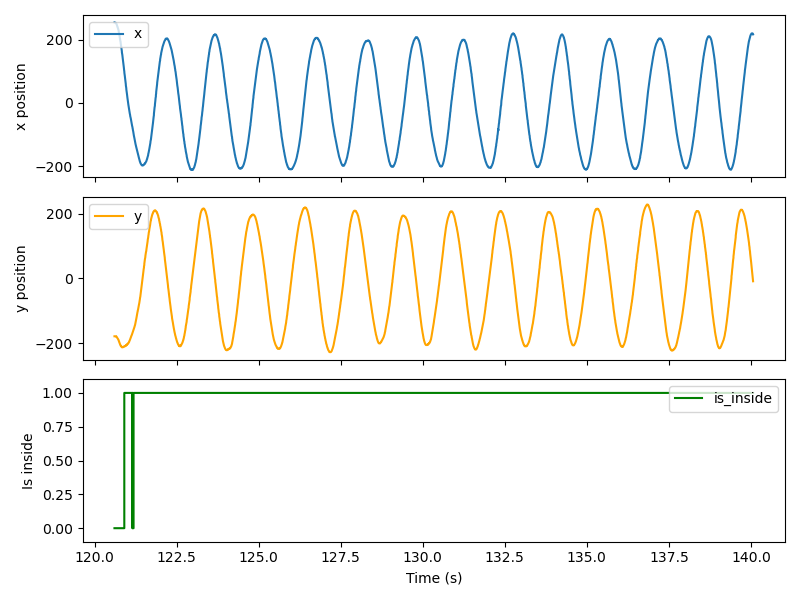

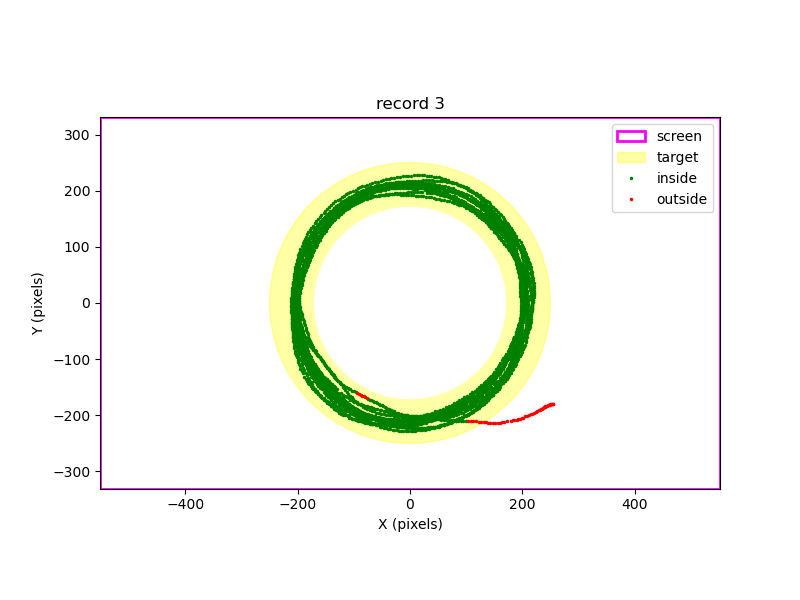

In [110]:
# Record 3 plots: trajectory with screen/target + x, y, is_inside vs time

# Ensure paths
base_dir = os.getcwd()
raw_csv = globals().get('raw_csv', os.path.join(base_dir, '001MoDe_R1.csv'))
marker_csv = globals().get('marker_csv', os.path.join(base_dir, '001MoDe_R1.marker.csv'))

# Helper to find header line for numeric table in raw csv
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    raise RuntimeError('Could not find data header in %s' % path)

# Parse parameter header if not already available
if 'params' not in globals():
    with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
        param_line = f.readline().strip()
    params = {}
    for part in param_line.split(';'):
        part = part.strip()
        if not part:
            continue
        if ' ' in part:
            k, v = part.split(' ', 1)
            k = k.strip(); v = v.strip()
            try:
                params[k] = float(v)
            except Exception:
                params[k] = v

# Extract dimensions and radii
screen_w = int(params.get('screenWidth', 1104))
screen_h = int(params.get('screenHeight', 661))
center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw data arrays if needed
if 't_sec' not in globals() or 'x_rel' not in globals() or 'y_rel' not in globals() or 'in_target' not in globals() or 'start_times' not in globals() or 'end_times' not in globals():
    header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
    raw_data = np.genfromtxt(
        raw_csv,
        delimiter=',',
        names=True,
        skip_header=header_line,
        dtype=None,
        encoding=None
    )
    timestamps = raw_data['timestamp'].astype(np.int64)
    sort_idx = np.argsort(timestamps)
    timestamps = timestamps[sort_idx]
    mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
    mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
    in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]
    # relative coordinates (origin at screen center), invert y so up is positive
    x_rel = mouse_x - center_x
    y_rel = (center_y - mouse_y)
    # parse record intervals from marker file
    starts_epoch = []
    ends_epoch = []
    with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
                parts = [p.strip() for p in s.split(',')]
                if len(parts) >= 3:
                    try:
                        epoch_ms = int(parts[1])
                    except Exception:
                        continue
                    if 'DoCycleChange:DoRecord' in s:
                        starts_epoch.append(epoch_ms)
                    elif 'DoCycleChange:DoPause' in s:
                        ends_epoch.append(epoch_ms)
    t0_record = int(starts_epoch[0])
    t_sec = (timestamps - t0_record) / 1000.0
    start_times = np.array([(ms - t0_record) / 1000.0 for ms in starts_epoch], dtype=float)
    end_times = np.array([(ms - t0_record) / 1000.0 for ms in ends_epoch], dtype=float)

# ---- Select record 3 ----
rec_idx = 3
if rec_idx >= len(start_times):
    raise IndexError("Record 3 not found in markers.")

mask3 = (t_sec >= start_times[rec_idx]) & (t_sec <= end_times[rec_idx])
ins3 = (in_target[mask3] == 1)

x3 = x_rel[mask3]
y3 = y_rel[mask3]
t3 = t_sec[mask3]

# ---- Plot A: XY trajectory with screen and target annulus (record 3) ----
figA, axA = plt.subplots(1, 1, figsize=(8, 6))
axA.add_patch(Rectangle((-screen_w/2, -screen_h/2), screen_w, screen_h,
                        fill=False, edgecolor='magenta', linewidth=2, label='screen'))
outer = Circle((0, 0), external_r, color='yellow', alpha=0.35, fill=True, label='target')
inner = Circle((0, 0), internal_r, color='white', alpha=1.0, fill=True)
axA.add_patch(outer)
axA.add_patch(inner)
axA.plot(x3[ins3], y3[ins3], '.', color='green', markersize=3, label='inside')
axA.plot(x3[~ins3], y3[~ins3], '.', color='red', markersize=3, label='outside')
axA.set_title('record 3')
axA.set_xlabel('X (pixels)')
axA.set_ylabel('Y (pixels)')
axA.set_aspect('equal', adjustable='box')
axA.set_xlim(-screen_w/2, screen_w/2)
axA.set_ylim(-screen_h/2, screen_h/2)
axA.legend(loc='upper right')
axA.grid(False)

# ---- Plot B: x, y and is_inside vs time (record 3) ----
figB, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(t3, x3, color='tab:blue', label='x')
axes[0].set_ylabel('x position')
axes[0].legend(loc='upper left')

axes[1].plot(t3, y3, color='orange', label='y')
axes[1].set_ylabel('y position')
axes[1].legend(loc='upper left')

axes[2].plot(t3, ins3.astype(int), color='green', drawstyle='steps-post', label='is_inside')
axes[2].set_ylim(-0.1, 1.1)
axes[2].set_ylabel('Is inside')
axes[2].set_xlabel('Time (s)')
axes[2].legend(loc='upper right')

figB.tight_layout()
plt.show()

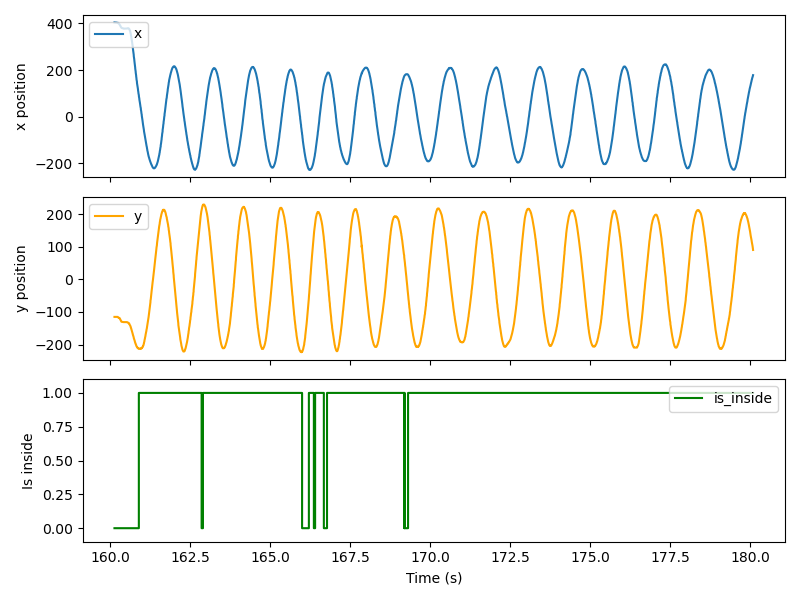

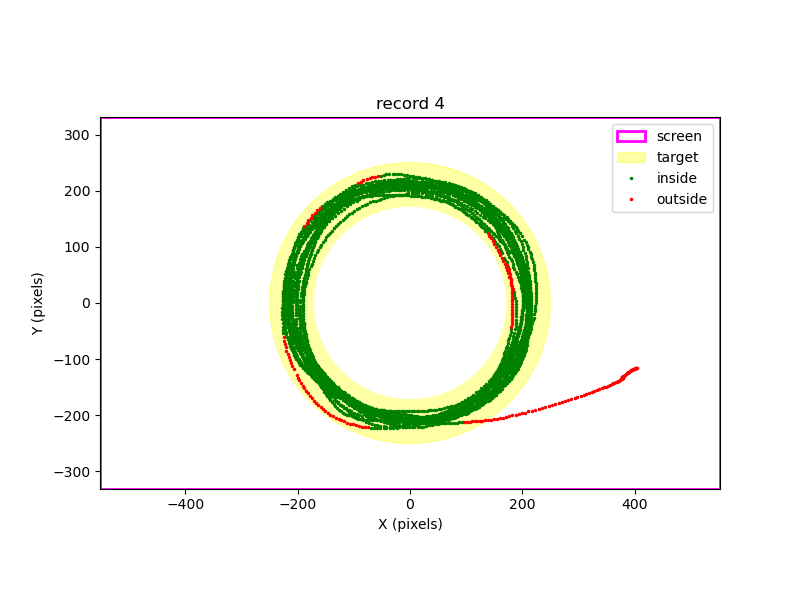

In [111]:
# Record 4 plots: trajectory with screen/target + x, y, is_inside vs time

# Ensure paths
base_dir = os.getcwd()
raw_csv = globals().get('raw_csv', os.path.join(base_dir, '001MoDe_R1.csv'))
marker_csv = globals().get('marker_csv', os.path.join(base_dir, '001MoDe_R1.marker.csv'))

# Helper to find header line for numeric table in raw csv
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    raise RuntimeError('Could not find data header in %s' % path)

# Parse parameter header if not already available
if 'params' not in globals():
    with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
        param_line = f.readline().strip()
    params = {}
    for part in param_line.split(';'):
        part = part.strip()
        if not part:
            continue
        if ' ' in part:
            k, v = part.split(' ', 1)
            k = k.strip(); v = v.strip()
            try:
                params[k] = float(v)
            except Exception:
                params[k] = v

# Extract dimensions and radii
screen_w = int(params.get('screenWidth', 1104))
screen_h = int(params.get('screenHeight', 661))
center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw data arrays if needed
if 't_sec' not in globals() or 'x_rel' not in globals() or 'y_rel' not in globals() or 'in_target' not in globals() or 'start_times' not in globals() or 'end_times' not in globals():
    header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
    raw_data = np.genfromtxt(
        raw_csv,
        delimiter=',',
        names=True,
        skip_header=header_line,
        dtype=None,
        encoding=None
    )
    timestamps = raw_data['timestamp'].astype(np.int64)
    sort_idx = np.argsort(timestamps)
    timestamps = timestamps[sort_idx]
    mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
    mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
    in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]
    # relative coordinates (origin at screen center), invert y so up is positive
    x_rel = mouse_x - center_x
    y_rel = (center_y - mouse_y)
    # parse record intervals from marker file
    starts_epoch = []
    ends_epoch = []
    with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
                parts = [p.strip() for p in s.split(',')]
                if len(parts) >= 3:
                    try:
                        epoch_ms = int(parts[1])
                    except Exception:
                        continue
                    if 'DoCycleChange:DoRecord' in s:
                        starts_epoch.append(epoch_ms)
                    elif 'DoCycleChange:DoPause' in s:
                        ends_epoch.append(epoch_ms)
    t0_record = int(starts_epoch[0])
    t_sec = (timestamps - t0_record) / 1000.0
    start_times = np.array([(ms - t0_record) / 1000.0 for ms in starts_epoch], dtype=float)
    end_times = np.array([(ms - t0_record) / 1000.0 for ms in ends_epoch], dtype=float)

# ---- Select record 4 ----
rec_idx = 4
if rec_idx >= len(start_times):
    raise IndexError("Record 4 not found in markers.")

mask4 = (t_sec >= start_times[rec_idx]) & (t_sec <= end_times[rec_idx])
ins4 = (in_target[mask4] == 1)

x4 = x_rel[mask4]
y4 = y_rel[mask4]
t4 = t_sec[mask4]

# ---- Plot A: XY trajectory with screen and target annulus (record 4) ----
figA, axA = plt.subplots(1, 1, figsize=(8, 6))
axA.add_patch(Rectangle((-screen_w/2, -screen_h/2), screen_w, screen_h,
                        fill=False, edgecolor='magenta', linewidth=2, label='screen'))
outer = Circle((0, 0), external_r, color='yellow', alpha=0.35, fill=True, label='target')
inner = Circle((0, 0), internal_r, color='white', alpha=1.0, fill=True)
axA.add_patch(outer)
axA.add_patch(inner)
axA.plot(x4[ins4], y4[ins4], '.', color='green', markersize=3, label='inside')
axA.plot(x4[~ins4], y4[~ins4], '.', color='red', markersize=3, label='outside')
axA.set_title('record 4')
axA.set_xlabel('X (pixels)')
axA.set_ylabel('Y (pixels)')
axA.set_aspect('equal', adjustable='box')
axA.set_xlim(-screen_w/2, screen_w/2)
axA.set_ylim(-screen_h/2, screen_h/2)
axA.legend(loc='upper right')
axA.grid(False)

# ---- Plot B: x, y and is_inside vs time (record 4) ----
figB, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(t4, x4, color='tab:blue', label='x')
axes[0].set_ylabel('x position')
axes[0].legend(loc='upper left')

axes[1].plot(t4, y4, color='orange', label='y')
axes[1].set_ylabel('y position')
axes[1].legend(loc='upper left')

axes[2].plot(t4, ins4.astype(int), color='green', drawstyle='steps-post', label='is_inside')
axes[2].set_ylim(-0.1, 1.1)
axes[2].set_ylabel('Is inside')
axes[2].set_xlabel('Time (s)')
axes[2].legend(loc='upper right')

figB.tight_layout()
plt.show()